## Sustituyendo el contraste para dos poblaciones independientes por la inferencia Bayesiana

Vamos a trabajar con un conjunto de datos público, para analizar la estatura de hombres y mujeres. Descargamos el conjunto de datos del [NCD Risk Factor Collaboration](https://www.ncdrisc.org/data-downloads-height.html) especifico por países (Country-specific).

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns

In [2]:
data_all = pd.read_csv("datasets/NCD_RisC_Lancet_2020_height_child_adolescent_country.csv")
print(data_all)

            Country    Sex  Year  Age group  Mean height  \
0       Afghanistan   Boys  1985          5   103.315204   
1       Afghanistan   Boys  1985          6   109.235659   
2       Afghanistan   Boys  1985          7   114.759466   
3       Afghanistan   Boys  1985          8   120.002304   
4       Afghanistan   Boys  1985          9   125.077305   
...             ...    ...   ...        ...          ...   
209995     Zimbabwe  Girls  2019         15   156.994944   
209996     Zimbabwe  Girls  2019         16   158.066542   
209997     Zimbabwe  Girls  2019         17   158.724366   
209998     Zimbabwe  Girls  2019         18   159.220151   
209999     Zimbabwe  Girls  2019         19   159.849064   

        Mean height lower 95% uncertainty interval  \
0                                        92.912414   
1                                        99.914439   
2                                       106.310048   
3                                       112.202520   
4        

Vamos a hacer un análisis global de las poblaciones de adultos por lo tanto nos quedaremos sólo con los mayores de 18 años (i.e., "Age group == 19).

In [3]:
data = data_all.groupby("Age group").get_group(19).drop(
    columns=["Age group","Mean height lower 95% uncertainty interval","Mean height upper 95% uncertainty interval"])
print(data)

            Country    Sex  Year  Mean height  Mean height standard error
14      Afghanistan   Boys  1985   165.274786                    3.237744
29      Afghanistan   Boys  1986   165.430748                    3.051448
44      Afghanistan   Boys  1987   165.597909                    2.874716
59      Afghanistan   Boys  1988   165.778218                    2.709736
74      Afghanistan   Boys  1989   165.955873                    2.558171
...             ...    ...   ...          ...                         ...
209939     Zimbabwe  Girls  2015   159.829074                    0.608092
209954     Zimbabwe  Girls  2016   159.821971                    0.633202
209969     Zimbabwe  Girls  2017   159.822208                    0.662293
209984     Zimbabwe  Girls  2018   159.831314                    0.695402
209999     Zimbabwe  Girls  2019   159.849064                    0.732247

[14000 rows x 5 columns]


Axes(0.1,0.15;0.8x0.75)


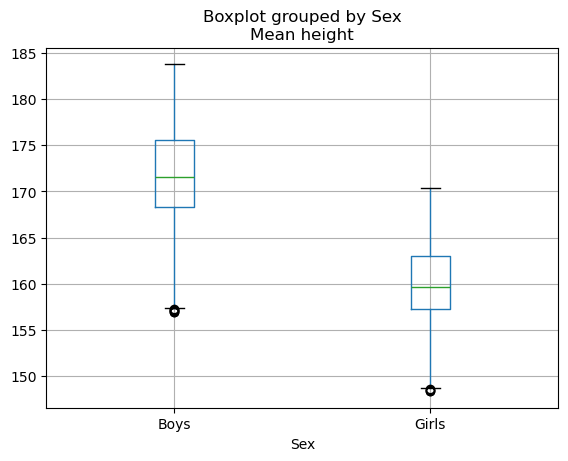

In [4]:
print(data.boxplot('Mean height', by='Sex'))
data_boys  = data.groupby("Sex").get_group("Boys").loc[:,["Mean height","Mean height standard error"]]
data_girls = data.groupby("Sex").get_group("Girls").loc[:,["Mean height","Mean height standard error"]]

### Paso 1: Definimos el modelo probabilístico a priori

El primer paso consiste en definir un modelo probabilístico completo para el problema en cuestión. De las observaciones podemos deducir que una buena distribución para modelar los datos es la distribución t-Student, ya que se ajusta bien cuando existen datos atípicos tal y como se muestran en los diagramas de caja anteriores que tienen una distribución con varios puntos extremos (círculos negros). 

Es decir, 

$$X_1 \sim t(\nu, \mu_1, \sigma_1), \qquad X_2 \sim t(\nu, \mu_1, \sigma_1)$$

Observemos que hemos elegido una distribución t-Student general, es decir, con función de densidad

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$

la cual tiene tres parámetros: $\nu, \, \mu, \, \sigma$.

En nuestro ejemplo, y por motivos de simplificación, vamos a suponer que las dos distribuciones con las que modelamos los datos tienen el mismo parámetro $\nu$, pero distintos $\mu_i$ y $\sigma_i$.

Sin embargo, __no sabemos nada__ sobre los parámetros $\nu$, $\mu_i$ y $\sigma_i$ para $i=1,2$, es decir, a priori tenemos una gran incertidumbre de los posibles valores que tomarían dichos parámetros en nuestro modelo. Esa incertidumbre la podemos medir con un nuevo modelo probabilístico, como veremos a continuación.

Como las medias son valores reales, podemos modelarlas a través de una distribución normal, y fijar los parámetros de dichas distribuciones normales (esto es, sus hiperparámetros) de la siguiente manera. Su valor medio estará dado por las medias muestrales, y sus desviaciones típicas estrán dadas por dos veces la desviaciones típicas muestrales. De esta manera otorgamos a estas cantidades una información muy difusa, lo que significa que no hay predilección clara por ningún valor concreto. Lo dicho anteriormente se traduce a:

$$\mu_i \sim N(\bar{x}, 2s)$$

In [5]:
print("Media: ",data["Mean height"].mean())
print("Desviación estándar: ",data["Mean height"].std())

μ_m = data["Mean height"].mean()
μ_s = 2 * data["Mean height"].std()

model_tStudent = pm.Model()
with model_tStudent:
    girls_mean = pm.Normal('girls_mean',mu=μ_m, sigma=μ_s)
    boys_mean = pm.Normal('boys_mean',  mu=μ_m, sigma=μ_s)

Media:  165.86542228519284
Desviación estándar:  7.538602574134955


In [6]:
#model_normal = pm.Model()
#with model_normal:
#    girls_mean = pm.Normal('girls_mean', mu=μ_m, sigma=μ_s)
#    boys_mean  = pm.Normal('boys_mean', mu=μ_m, sigma=μ_s)

Para las desviaciones típicas $\sigma_i$ utilizaremos una distribución uniforme que contenga los valores plausibles en el rango de la variabilidad. 

__[Pregunta]__ ¿Por qué no hacer variar en un rango más amplio? Debemos tener en cuenta las restricciones físicas de las variables que estemos midiendo. No tiene sentido ampliar los espacios parámetricos. 

In [7]:
σ_low = 1  # 1 cm es la minima unidad de medida
σ_high = 200 # 200 cm es mucho

with model_tStudent:
    girls_std = pm.Uniform('girls_std', lower=σ_low, upper=σ_high)
    boys_std  = pm.Uniform('boys_std', lower=σ_low, upper=σ_high)
    ν = pm.Exponential('ν_minus_one', 1/30.) + 1

In [8]:
#with model_normal:
#    girls_std = pm.Uniform('girls_std', lower=σ_low, upper=σ_high)
#    boys_std  = pm.Uniform('boys_std',  lower=σ_low, upper=σ_high)

Finalmente, utilizamos como distribución a priori (previa) de $\nu$ una distribución exponencial de media 30. Esto posibilita obtener distribuciones que van desde la distribución normal (valores de $\nu$ grandes) hasta distribuciones con colas pesadas para incluir valores atípicos (valores de $\nu$ pequeños). En PyMC la distribución exponencial esta parametrizada como $f(x|\lambda)=\lambda Exp(-\lambda x)$, por lo que para obtener una media de 30 usamos como escala 1/30.

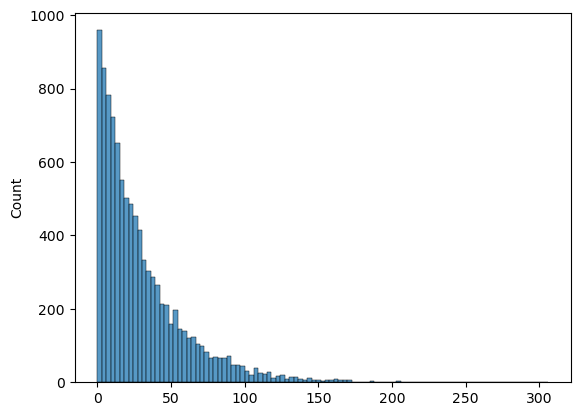

In [9]:
sns.histplot(np.random.exponential(30, size=10000), kde=False);

In [10]:
with model_tStudent:
    boys  = pm.StudentT('boys',  nu=ν, mu=boys_mean,  sigma=boys_std,  observed=data_boys["Mean height"])
    girls = pm.StudentT('girls', nu=ν, mu=girls_mean, sigma=girls_std, observed=data_girls["Mean height"])

In [11]:
#with model_normal:
#    boys  = pm.Normal('boys',  mu=boys_mean,  sigma=boys_std,  observed=data_boys["Mean height"])
#    girls = pm.Normal('girls', mu=girls_mean, sigma=girls_std, observed=data_girls["Mean height"])
#------------ Incertidumbre como la convolución del la observada más la modelada -----------------------
#    sigma_boys  = np.sqrt(boys_std**2 + data_boys["Mean height standard error"]**2)
#    sigma_girls = np.sqrt(girls_std**2 + data_girls["Mean height standard error"]**2)
#    boys  = pm.Normal('boys',  mu=boys_mean,  sigma=sigma_boys,  observed=data_boys["Mean height"])
#    girls = pm.Normal('girls', mu=girls_mean, sigma=sigma_girls, observed=data_girls["Mean height"])

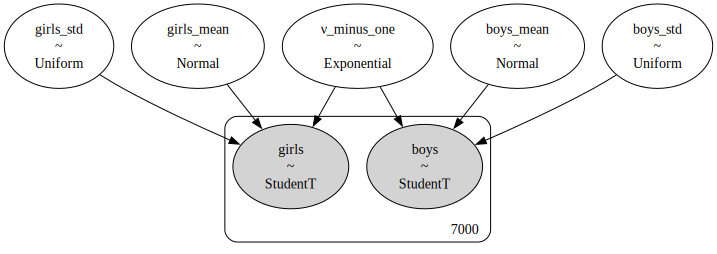

In [12]:
pm.model_to_graphviz(model_tStudent)
#pm.model_to_graphviz(model_normal)

Ya está definido completamente el modelo probabilístico. Ahora podemos generar cantidades de nuestro interés, como por ejemplo __la diferencia de medias__ o __la diferencia entre las desviaciones típicas__. También incluiremos __el tamaño del efecto__ a través de la [$d$ de Cohen](https://en.wikipedia.org/wiki/Effect_size#.22Small.22.2C_.22medium.22.2C_.22large.22_effect_sizes), es decir,  una diferencia de medias estandarizada. O dicho de otro modo, una medida de cuántas desviaciones típicas de diferencia hay entre los resultados de los dos grupos que se comparan (grupo experimental y grupo de control).

In [13]:
with model_tStudent:
    diff_of_means = pm.Deterministic('difference of means', boys_mean - girls_mean)
    diff_of_stds = pm.Deterministic('difference of stds', boys_std - girls_std)
    effect_size = pm.Deterministic('effect size',diff_of_means / np.sqrt((boys_std**2 + girls_std**2) / 2))

In [14]:
#with model_normal:
#    diff_of_means = pm.Deterministic('difference of means', boys_mean - girls_mean)
#    diff_of_stds = pm.Deterministic('difference of stds', boys_std - girls_std)
#    effect_size = pm.Deterministic('effect size',diff_of_means / np.sqrt((boys_std**2 + girls_std**2) / 2))

### Paso 2: Actualizamos el modelo a partir de las observaciones

Obtenemos la distribución posterior como muestras que se generan utilizando el algoritmo NUTS.

In [15]:
with model_tStudent:
#with model_normal:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [girls_mean, boys_mean, girls_std, boys_std, ν_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Podemos ver alguna de las cadenas de Markov calculadas

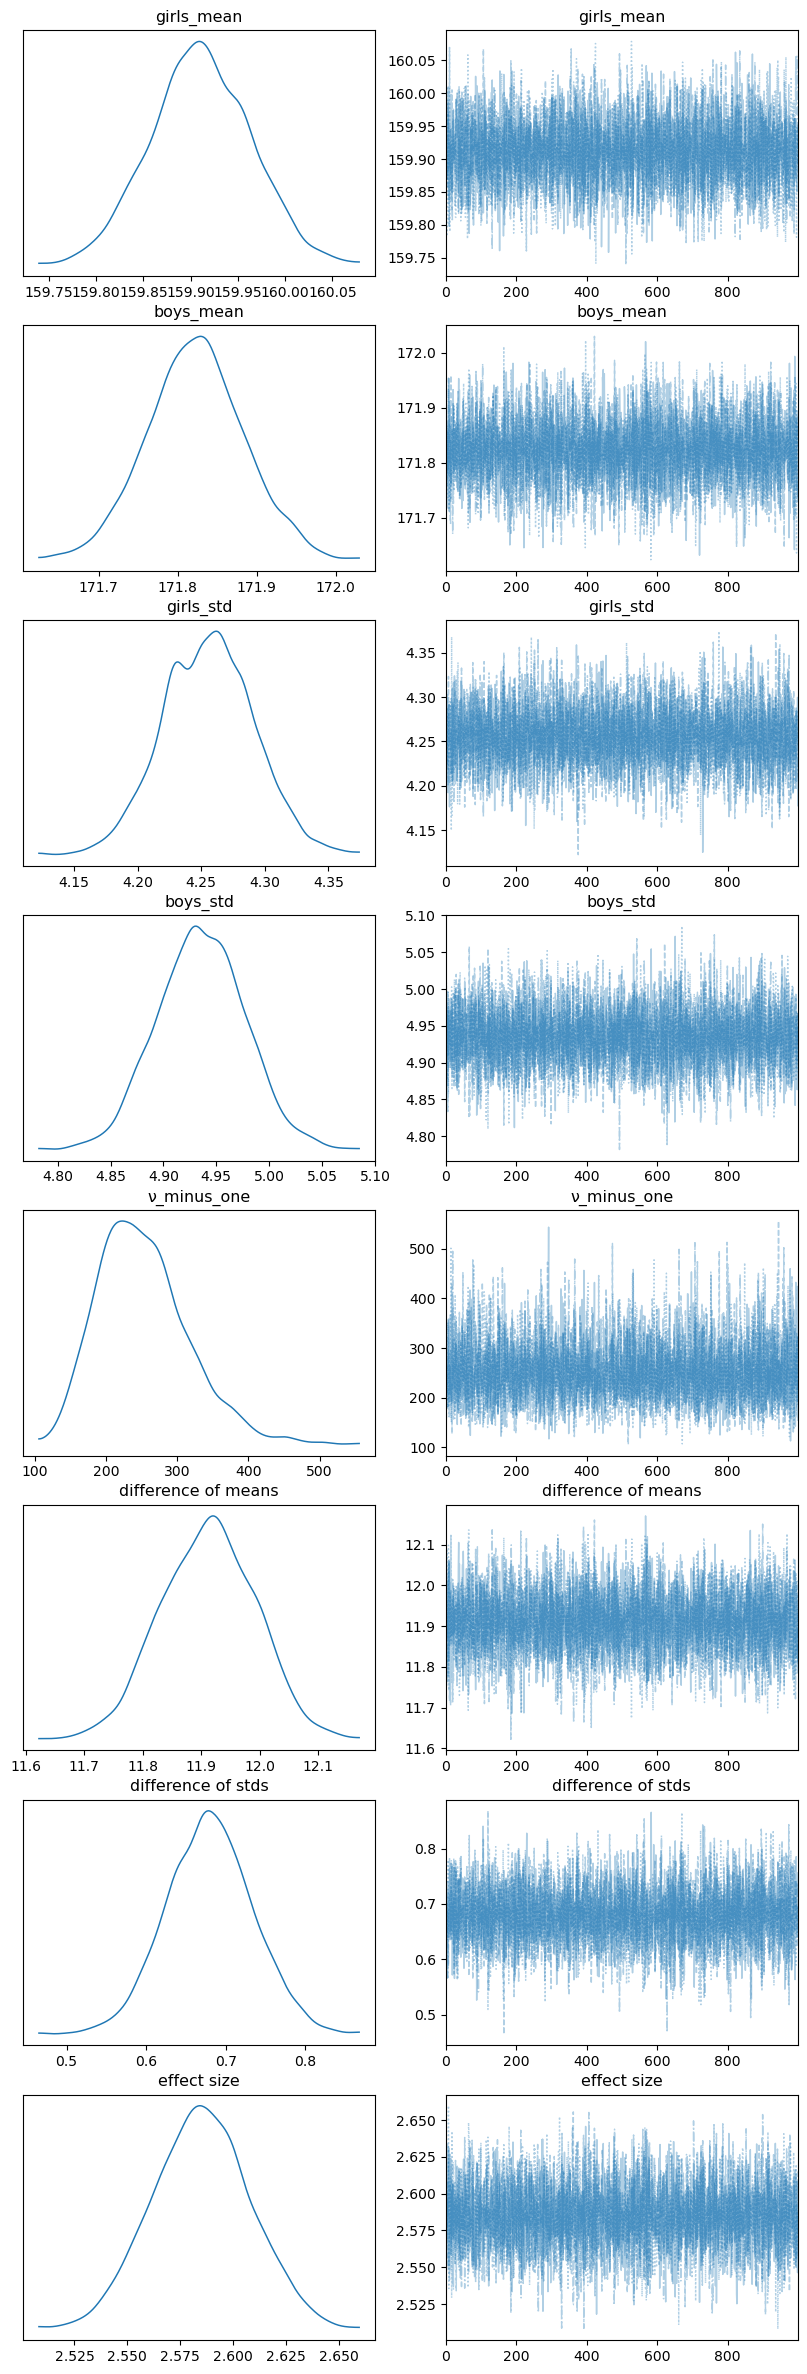

In [18]:
with model_tStudent:
#with model_normal:
    az.plot_trace(samples,combined=True,figsize=(10,30))

Podemos pintar ahora las distribución posterior de los parámetros.

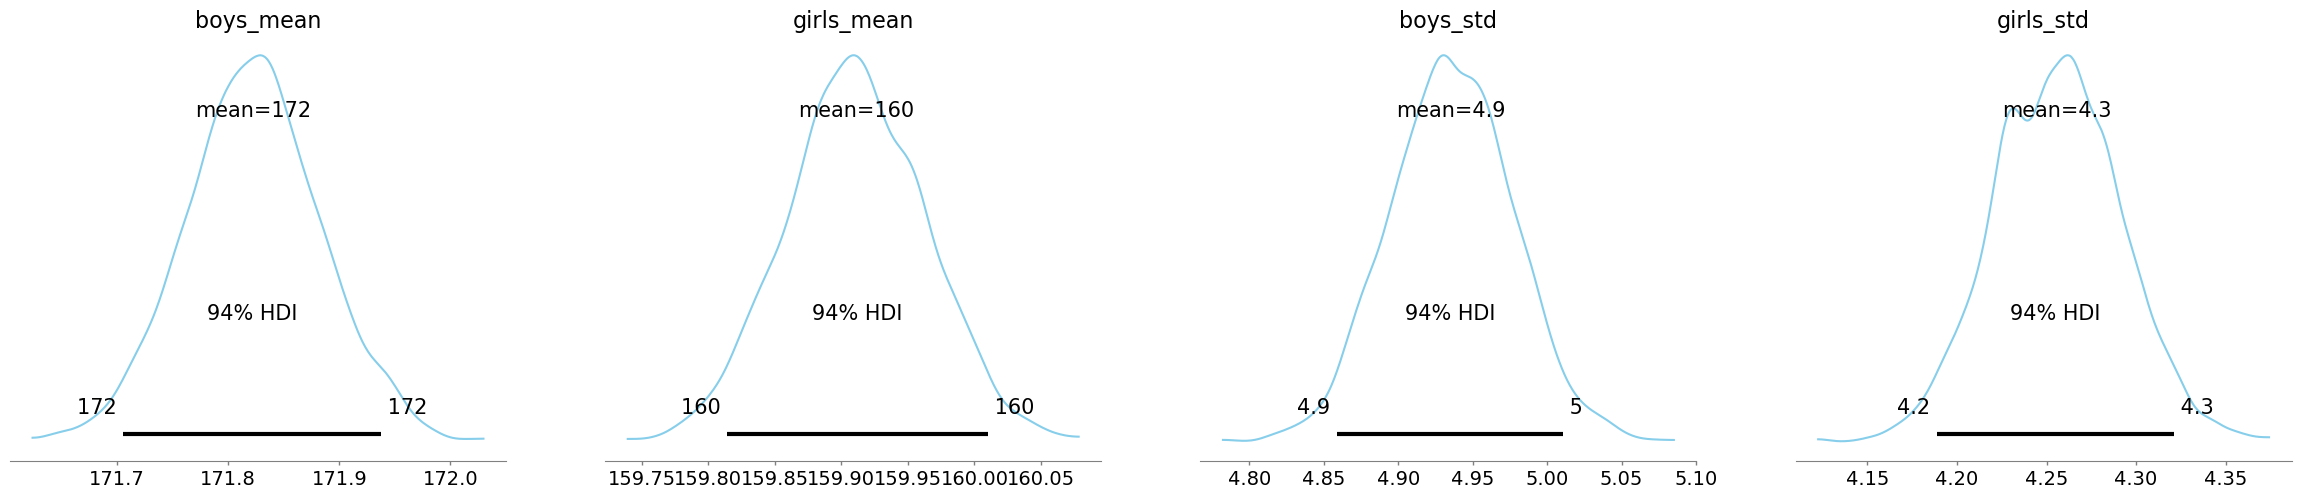

In [19]:
with model_tStudent:
#with model_normal:
    az.plot_posterior(samples,
                  var_names=['boys_mean','girls_mean', 'boys_std', 'girls_std'],
                  color='#87ceeb');


En cuanto a las cantidades generadas a partir de los parámetros, se puede concluir que existe diferencias significativas de los dos grupos para las tres cantidades calculadas. Es plausible, por tanto que 

$$ \mu_1 - \mu_2 > 0, \qquad \sigma_1 - \sigma_2 >0 $$


Estas estimaciones sugieren que la diferencia es significativa ya que las medias están a 2.6 desviaciones estándar.

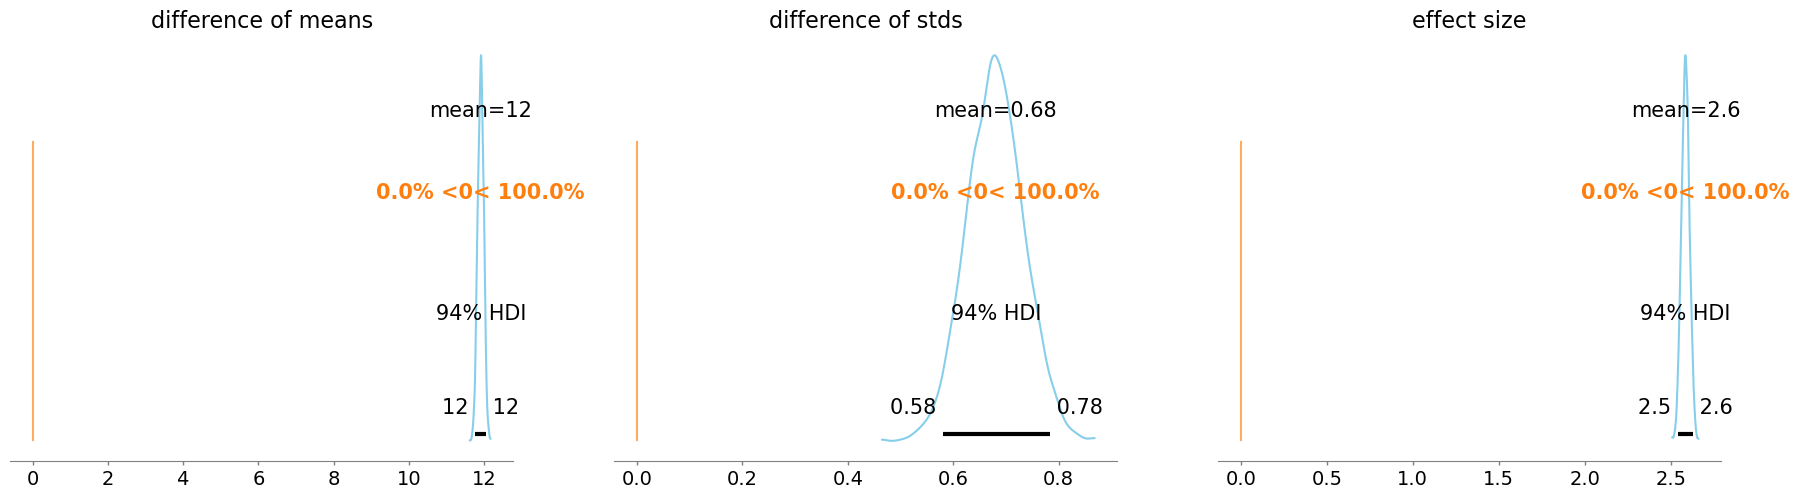

In [20]:
with model_tStudent:
#with model_normal:
    az.plot_posterior(samples,
                  var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

Ejercicios:
1. Juega con los parámetros del prior. ¿Cambian los resultados al modificar los valores de los hiperparámetros?
2. La distribución Student-t converje a una normal cuando los grados de libertad tienden a infinito ([Prueba](https://www.statlect.com/probability-distributions/student-t-distribution)). Reemplaza la verosimilitud Student-t por una normal e infiere de nuevo la distribución posterior. ¿Cambian las conclusiones bajo el nuevo modelo?
3. En el modelo con verosimilitud normal, introduce la incertidumbre observada como la convolución de la incertidumbre modelada más la observada. ¿Cómo cambian los resultados?

Extra. Seleccióna una edad entre 5 y 18 años, incluidos los extremos. Repite el ejercicio 3 utilizando esta edad en vez de los 19 años. ¿Cómo de significativa (effect size) es la diferencia de alturas entre hombres y mujeres? 